In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import numpy as np
plt.style.use('seaborn-pastel')
sns.set_style("whitegrid")

import warnings #출력문제로 나타나는 경고 무시
warnings.filterwarnings("ignore")

#한글 시각화
import matplotlib
from matplotlib import font_manager, rc


font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)
matplotlib.rcParams['axes.unicode_minus'] = False

#  데이터 Load
###### 사용 데이터셋
- 1. 전국교통 안전지수데이터(시군구)
- 2. 사고데이터
- 3. 도로링크데이터


In [2]:
전국교통안전지수 = pd.read_excel('data/전국교통안전지수+차량둥록수+인구수_final.xlsx', encoding = 'EUC-KR', index_col = 0)
전국사고데이터 = pd.read_csv('data/전국사고_시군구전처리229개.csv', engine ='python', encoding = 'utf-8', index_col = 0)
전국링크데이터 = pd.read_csv('data/전국링크데이터_SIG_CD전처리.csv', index_col = 0)

전국교통안전지수.tail()

# 227개의 지자체 + (울릉군+옹진군) 을 임의로 추가해줘서 229개의 지자체가 됨

,SIG_CD,SIG_ENG_NM,시군구,구분,최종점수,전체등급,교통약자 지수,교통약자등급,운전자 지수,운전자 등급,도로환경 지수,도로환경 등급,자동차등록대수,인구수
224,48870,Hamyang-gun,함양군,경남,81.72,C,80.99,C,80.35,C,81.31,D,19740,40044
225,48880,Geochang-gun,거창군,경남,82.82,C,82.73,C,83.92,B,83.81,C,107282,62455
226,48890,Hapcheon-gun,합천군,경남,82.31,C,82.76,C,83.14,B,84.88,B,23812,45916
227,50110,Jeju-si,제주시,제주,74.58,C,73.74,C,77.76,B,70.42,C,59569,485946
228,50130,Seogwipo-si,서귀포시,제주,72.28,E,72.31,D,70.83,E,61.28,E,73285,181245


# 1. 전국교통안전지수 EDA
- __교통안전지수__는 도로교통공단(KoRoad)에서 산출한 점수

In [3]:
#상위10위와 하위 10위를 대조적으로 비교하기 위한 그래프 생성 함수
def 상위10하위10전국그래프(df, column):
    
    Top10 = df.sort_values(by = column , ascending=False)[['시군구',column]][:10]  #상위10개
    Bot10 = df.sort_values(by = column, ascending=False)[['시군구',column]][-10:]  #하위10개
    Top10_Bot10 = Top10.append(Bot10, ignore_index = True) #
    
    plt.figure(figsize = (18,4))

    plt.title('상위10개, 하위 10개 전국 시군구의 ' + column, fontweight="bold") 

    plt.axhline(df[column].mean(), color = 'purple' , linestyle='--') # 지수 평균 수평선
    plt.axvline(9.5, linewidth = 5 , ls = '--')   #상위10위, 하위10위 구분 경계선


    xs = Top10_Bot10['시군구'].values              # x축
    ys = Top10_Bot10[column].values                # y축

    ax = sns.barplot(x = xs, y = ys )
    
    
    if '청주시' in str(Top10_Bot10['시군구'].values):                     #만약 상위또는 하위10위에 청주시 존재한다면
        L = Top10_Bot10[Top10_Bot10['시군구']=='청주시'].index[0] - 0.5   #청주시를 빨간네모박스로 강조 시각화
        RedBox_height = (Top10_Bot10[Top10_Bot10['시군구']=='청주시'][column].values[0])

        rect = patches.Rectangle((L , 4),1, RedBox_height  ,linewidth=2.5 ,edgecolor='r',facecolor='none')
        ax.add_patch(rect)

    plt.show()

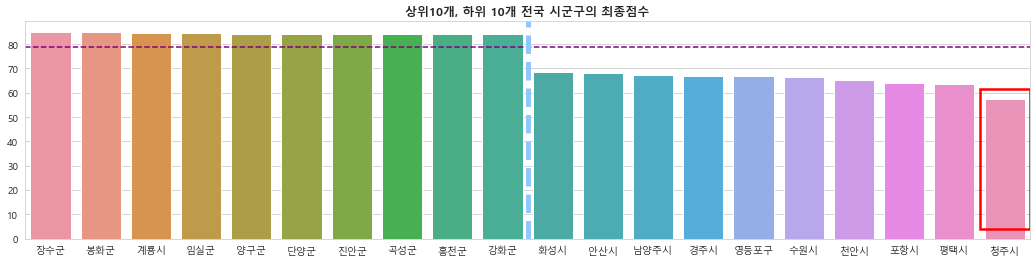

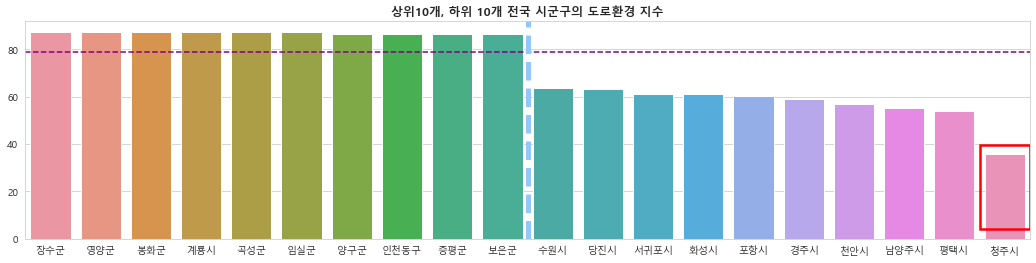

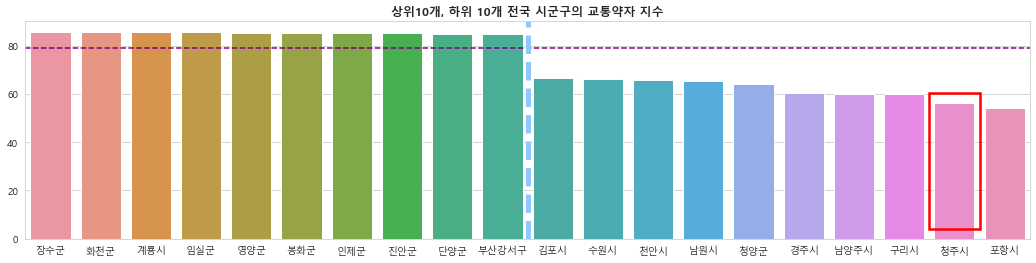

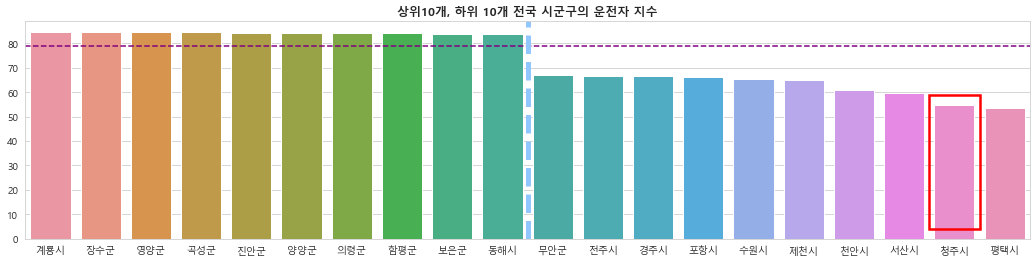

In [4]:
상위10하위10전국그래프(df = 전국교통안전지수 , column = '최종점수')
상위10하위10전국그래프(df = 전국교통안전지수 , column = '도로환경 지수')
상위10하위10전국그래프(df = 전국교통안전지수 , column = '교통약자 지수')
상위10하위10전국그래프(df = 전국교통안전지수 , column = '운전자 지수')

- 청주시의 __교통안전지수__도 227개 시군구 중 가장 최하위(227위)이고, 그 중 __도로환경지수__가 상당히 낮음을 볼 수 있다.

#####아래는 삭제할내용이지만 참고해야될 내용@@@ @@@@@@@@@@@@@@@@@@@@
전국시군구는 국룰이250개임
하지만 , 교통안전지수는 227개의 시군구만 주어짐.  + 울릉군+옹진군 인구수나 차량대수 merge를 위해 편의상 추가시켰음

# 2. 사고 분석 EDA
1. SCLAS (사고 차량 유형)
2. LCLAS (사고 크기 유형)
3. 요일데이터

In [5]:
전국사고데이터['SCLAS'].value_counts()

차대차     484044
차대사람    140456
차량단독     29847
Name: SCLAS, dtype: int64

##### 철길건널목과 건널목에 대한 데이터는 비교적 상당히 적으므로 제거
- 건널목이나 , 철길건널목에서 일어난 사고는 모두 제외

In [6]:
전국사고데이터 = 전국사고데이터[(전국사고데이터['SCLAS'] != '건널목') & (전국사고데이터['SCLAS'] !='철길건널목')]
전국사고데이터.head()

,OBJT_ID,OCCU_YEAR,OCCU_MT,OCCU_DE,OCCU_TM,OCCU_DAY,OCCU_DATE,LCLAS,SCLAS,사망자,...,음주사고,어린이사고,노인사고,보행자사고,VIOLT_CN,CTPRVN_CD,SIG_CD,EMD_CD,X,Y
0,1,2016,2,27,16,토요일,20160227,경상사고,차대차,0,...,0,0,0,0,안전거리 미확보,11,11110,11110101,1.413422e+07,4.521789e+06
1,2,2016,2,28,19,일요일,20160228,중상사고,차대차,0,...,0,0,0,0,안전운전 의무 불이행,11,11110,11110101,1.413420e+07,4.521219e+06
2,3,2016,3,28,7,월요일,20160328,중상사고,차대차,0,...,0,0,0,0,안전거리 미확보,11,11110,11110101,1.413455e+07,4.521176e+06
3,4,2016,4,5,13,화요일,20160405,경상사고,차대차,0,...,0,0,1,0,안전운전 의무 불이행,11,11110,11110101,1.413401e+07,4.521163e+06
4,5,2016,5,15,19,일요일,20160515,경상사고,차대차,0,...,0,1,0,0,안전거리 미확보,11,11110,11110101,1.413422e+07,4.521177e+06


##### 전국 사고데이터에서 청주데이터 분리
- 청주시 SGG : 43110

In [7]:
##### 1. 전국 사고데이터에서 청주데이터 분리
청주시사고데이터 = 전국사고데이터[전국사고데이터['SIG_CD'] == 43110]
청주시사고데이터.head(3)

,OBJT_ID,OCCU_YEAR,OCCU_MT,OCCU_DE,OCCU_TM,OCCU_DAY,OCCU_DATE,LCLAS,SCLAS,사망자,...,음주사고,어린이사고,노인사고,보행자사고,VIOLT_CN,CTPRVN_CD,SIG_CD,EMD_CD,X,Y
456202,456203,2016,1,28,22,목요일,20160128,중상사고,차대사람,0,...,0,0,0,1,기타,43,43110,43111101,1.419145e+07,4.388559e+06
456203,456204,2016,1,30,20,토요일,20160130,중상사고,차대사람,0,...,0,0,0,1,안전운전 의무 불이행,43,43110,43111101,1.419171e+07,4.388591e+06
456204,456205,2016,2,5,7,금요일,20160205,경상사고,차대차,0,...,0,0,0,0,신호위반,43,43110,43111101,1.419119e+07,4.389651e+06


In [8]:
청주시사고데이터.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14883 entries, 456202 to 471085
Data columns (total 23 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   OBJT_ID    14883 non-null  int64  
 1   OCCU_YEAR  14883 non-null  int64  
 2   OCCU_MT    14883 non-null  int64  
 3   OCCU_DE    14883 non-null  int64  
 4   OCCU_TM    14883 non-null  int64  
 5   OCCU_DAY   14883 non-null  object 
 6   OCCU_DATE  14883 non-null  int64  
 7   LCLAS      14883 non-null  object 
 8   SCLAS      14883 non-null  object 
 9   사망자        14883 non-null  int64  
 10  중상자        14883 non-null  int64  
 11  경상자        14883 non-null  int64  
 12  부상자        14883 non-null  int64  
 13  음주사고       14883 non-null  int64  
 14  어린이사고      14883 non-null  int64  
 15  노인사고       14883 non-null  int64  
 16  보행자사고      14883 non-null  int64  
 17  VIOLT_CN   14883 non-null  object 
 18  CTPRVN_CD  14883 non-null  int64  
 19  SIG_CD     14883 non-null  int64  
 20  

##### 사고유형 비교

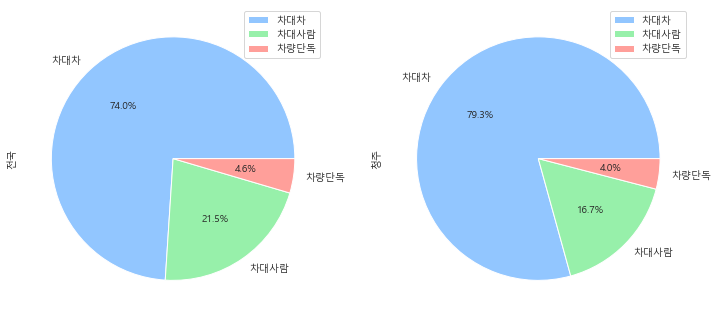

In [9]:
plt.rcParams['figure.figsize'] = [12, 8]

pd.DataFrame({'전국' : 전국사고데이터['SCLAS'].value_counts(),
              '청주' : 청주시사고데이터['SCLAS'].value_counts()}).plot(kind = 'pie' ,  autopct='%1.1f%%', subplots=True)
plt.show()

>- __차대차 사고__ 비율이 전국보다 비교적 높은것을 볼 수 있다.

##### 청주시와 전국 사고데이터 비교
- 사고 유형
- 사고 차량 유형
- 요일별 비교
- 월별 비교

In [10]:
def 비교시각화(df_청주 , df_전국 , column):
    
    df = pd.DataFrame({'청주시' : df_청주[column].value_counts(normalize = True),
                       '전국' : df_전국[column].value_counts(normalize = True)})
    
    ax = df.plot(kind = 'bar', figsize = (15,4))
    ax.set_title('청주시와 전국의 ' + column +' 비교', fontsize = 25, fontweight="bold")

    plt.xticks(rotation = 0)
    for p in ax.patches:

        height = p.get_height()

        ax.text(x = p.get_x()+p.get_width()/2., 
                y = height,
                s = str(np.round(height*100,1)) + '%' 
                ,ha="center",fontsize=12)
    plt.show()

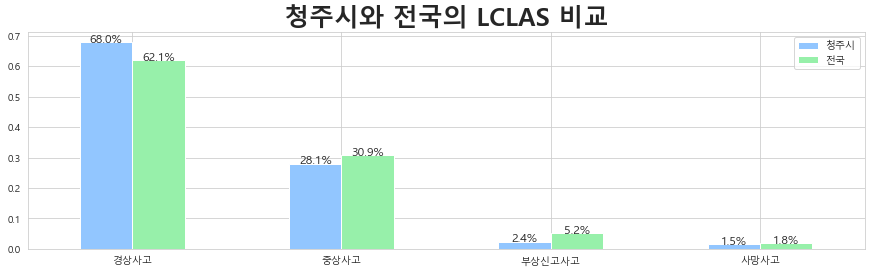

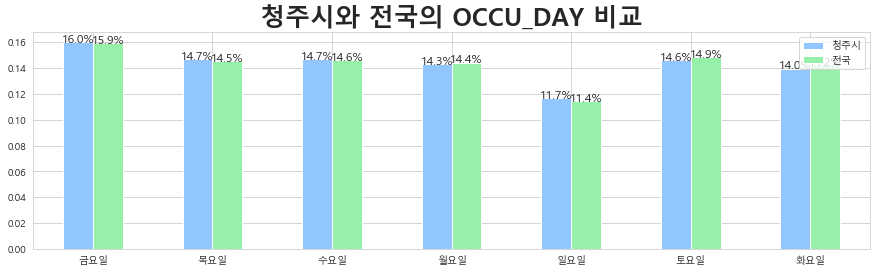

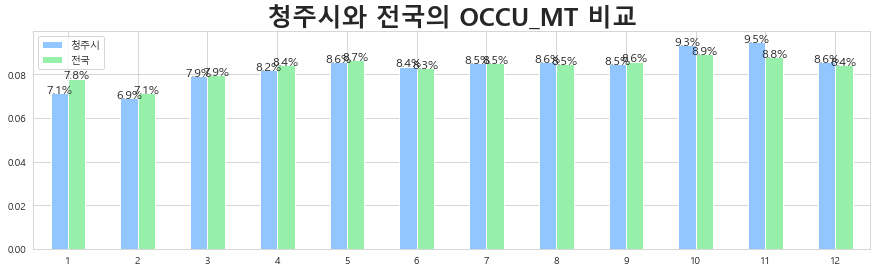

In [11]:
비교시각화(청주시사고데이터, 전국사고데이터, 'LCLAS')
비교시각화(청주시사고데이터, 전국사고데이터, 'OCCU_DAY')
비교시각화(청주시사고데이터, 전국사고데이터, 'OCCU_MT')

##### 사고데이터 시군구별로 분석

In [12]:
지역별사고데이터 = 전국사고데이터.groupby('SIG_CD').count().iloc[:,0].reset_index()
지역별사고데이터 = pd.merge(지역별사고데이터 , 전국교통안전지수[['SIG_CD','시군구']] , on = 'SIG_CD')
지역별사고데이터 = 지역별사고데이터.rename(columns = {'OBJT_ID' : '사고건수'})
지역별사고데이터 = 지역별사고데이터.sort_values(by = '사고건수')
지역별사고데이터

,SIG_CD,사고건수,시군구
208,47940,57,울릉군
58,28720,108,옹진군
159,45740,175,장수군
157,45720,210,진안군
141,44250,224,계룡시
...,...,...,...
84,41280,11185,고양시
76,41130,11316,성남시
83,41270,11358,안산시
124,43110,14883,청주시


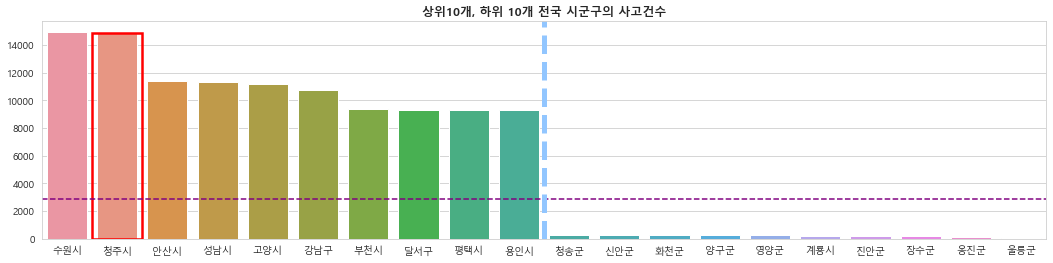

In [13]:
상위10하위10전국그래프(df = 지역별사고데이터 , column = '사고건수')

>- 사고건수가 청주시가 전국 지자체 사고 2위인것을 볼 수 있다.
>- 도로가 많고 , 차량이 많다면 그에 비례할 수 있으므로 , 도로길이와 면허소지량을 고려

In [14]:
교통사고피해 = 전국사고데이터.groupby('SIG_CD').sum().loc[:,'사망자':'부상자'].reset_index()
교통사고피해 = 교통사고피해.merge(전국교통안전지수[['SIG_CD','시군구']] , on = 'SIG_CD')
교통사고피해

,SIG_CD,사망자,중상자,경상자,부상자,시군구
0,11110,28,1096,3287,600,종로구
1,11140,30,1256,3113,537,서울중구
2,11170,38,1264,4193,413,용산구
3,11200,39,1081,3002,520,성동구
4,11215,35,1101,2985,295,광진구
...,...,...,...,...,...,...
224,48870,29,314,375,118,함양군
225,48880,35,517,465,33,거창군
226,48890,35,308,356,44,합천군
227,50110,135,2839,9455,1589,제주시


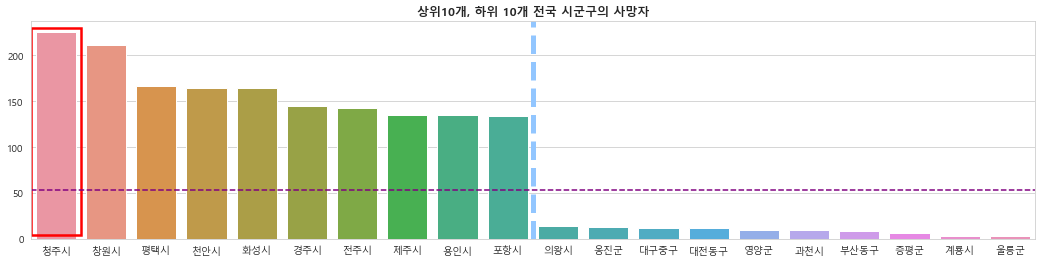

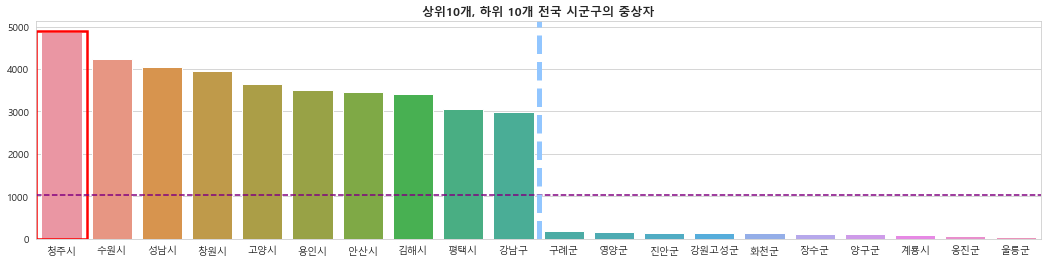

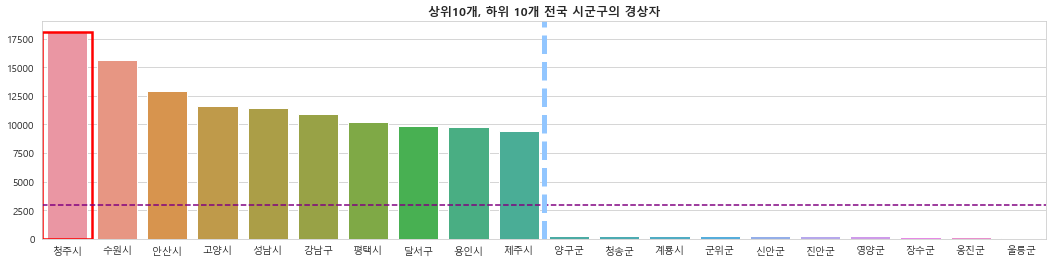

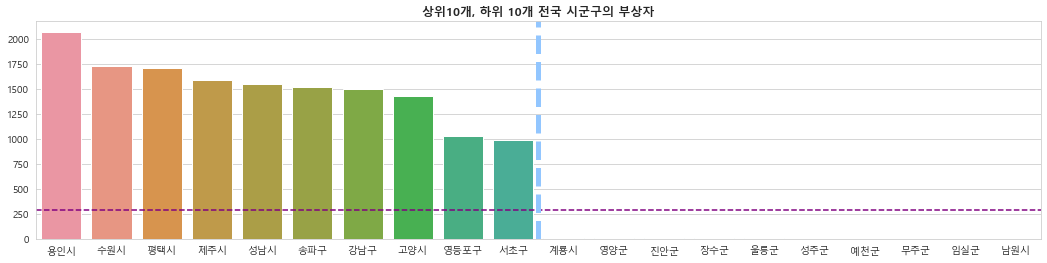

In [15]:
상위10하위10전국그래프(df = 교통사고피해, column = '사망자')
상위10하위10전국그래프(df = 교통사고피해, column = '중상자')
상위10하위10전국그래프(df = 교통사고피해, column = '경상자')
상위10하위10전국그래프(df = 교통사고피해, column = '부상자')


>- 청주시가 사망자나 중상자가 상당히 많은것을 볼 수 있음

In [16]:
교통사고특이유형 = 전국사고데이터.groupby('SIG_CD').sum().loc[:,'음주사고':'보행자사고'].reset_index()
교통사고특이유형 = 교통사고특이유형.merge(전국교통안전지수[['SIG_CD','시군구']] , on = 'SIG_CD')
교통사고특이유형.tail()

,SIG_CD,음주사고,어린이사고,노인사고,보행자사고,시군구
224,48870,57,23,226,93,함양군
225,48880,70,50,256,129,거창군
226,48890,39,17,240,97,합천군
227,50110,658,723,1359,2227,제주시
228,50130,348,264,835,703,서귀포시


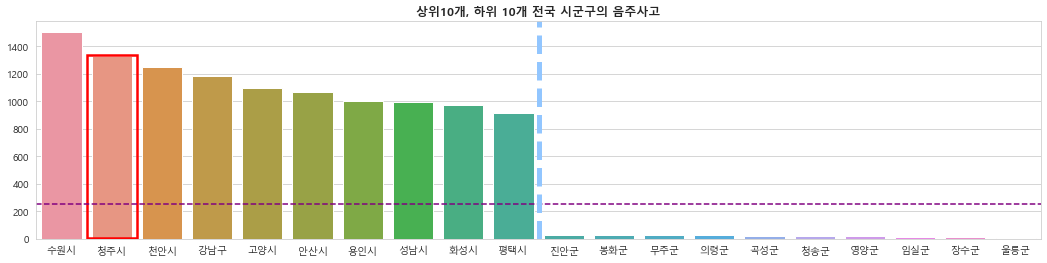

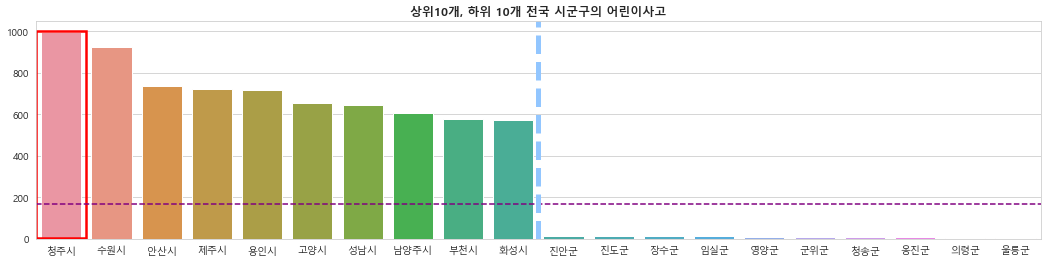

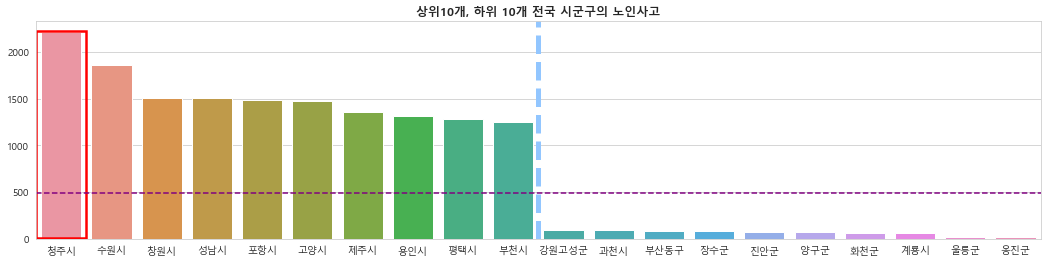

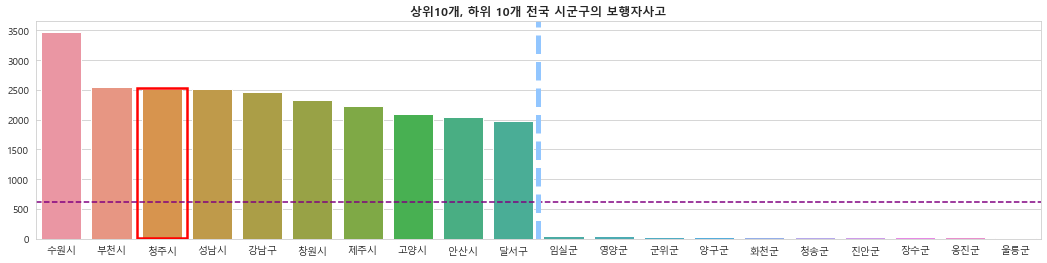

In [17]:
상위10하위10전국그래프(df = 교통사고특이유형, column = '음주사고')
상위10하위10전국그래프(df = 교통사고특이유형, column = '어린이사고')
상위10하위10전국그래프(df = 교통사고특이유형, column = '노인사고')
상위10하위10전국그래프(df = 교통사고특이유형, column = '보행자사고')

>- 어린이 교통사고와 노인사고가 상당히 많음을 볼 수 있다.
>- 보행자 사고는 총 사고건수가 가장 많은 수원시보다는 비교적 적은편임을 볼 수 있다. 

##### 지역별 사고건수 결합

In [18]:
최종merge_df = 전국교통안전지수.merge(지역별사고데이터.drop('시군구', axis = 1) , on = 'SIG_CD')
최종merge_df = 최종merge_df.set_index('시군구')
최종merge_df

,SIG_CD,SIG_ENG_NM,구분,최종점수,전체등급,교통약자 지수,교통약자등급,운전자 지수,운전자 등급,도로환경 지수,도로환경 등급,자동차등록대수,인구수,사고건수
시군구,,,,,,,,,,,,,,
종로구,11110,Jongno-gu,서울,77.67,D,82.13,C,81.56,C,80.77,C,102569,153065,3623
서울중구,11140,Jung-gu,서울,71.06,E,80.48,C,76.38,D,73.32,E,104849,125725,3668
용산구,11170,Yongsan-gu,서울,77.69,D,81.69,C,80.52,C,77.88,D,25775,228999,4095
성동구,11200,Seongdong-gu,서울,81.56,B,84.18,A,82.90,B,84.08,B,75869,308221,3318
광진구,11215,Gwangjin-gu,서울,80.78,C,84.01,A,81.34,C,83.15,B,13855,355559,3217
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
함양군,48870,Hamyang-gun,경남,81.72,C,80.99,C,80.35,C,81.31,D,19740,40044,537
거창군,48880,Geochang-gun,경남,82.82,C,82.73,C,83.92,B,83.81,C,107282,62455,762
합천군,48890,Hapcheon-gun,경남,82.31,C,82.76,C,83.14,B,84.88,B,23812,45916,539


# 시군구별 Clustering
- 인구수와 자동차등록대수를 활용한 시군구 군집화
- GMM(Gausian Mixture Models) clustering
- 시군구별 인구수와 자동차 등록대수의 차이가 상당히 큼
- 인구수와 자동차등록대수를 활용한 시군구 군집화

##### Min-Max Normalization (최소-최대 정규화)
- 클러스터링 하고자 하는 자동차등록대수와 인구수의 스케일을 맞춰주기 위해 정규화

In [19]:
X_scaled = 최종merge_df[['자동차등록대수','인구수']]
X_scaled.head()

X_scaled_std = (X_scaled - X_scaled.describe().min())  / (X_scaled.describe().max() - X_scaled.describe().min())
X_scaled_std.head()

,자동차등록대수,인구수
시군구,,
종로구,0.155309,0.127264
서울중구,0.158769,0.104498
용산구,0.038768,0.190493
성동구,0.114790,0.256460
광진구,0.020679,0.295877


##### 임의로 설정한 4개의 군집으로 , GaussianMixture Model을 사용한 Clustering

In [20]:
from sklearn.mixture import GaussianMixture

nclusters = 5  #군집의 수

gmm = GaussianMixture(n_components=nclusters) #GMM모델 생성
gmm.fit(X_scaled)

y_cluster_gmm = gmm.predict(X_scaled)

X_scaled_std['cluster'] = y_cluster_gmm

X_scaled_std.head()

,자동차등록대수,인구수,cluster
시군구,,,
종로구,0.155309,0.127264,4
서울중구,0.158769,0.104498,4
용산구,0.038768,0.190493,4
성동구,0.114790,0.256460,4
광진구,0.020679,0.295877,4


##### 군집화 시각화

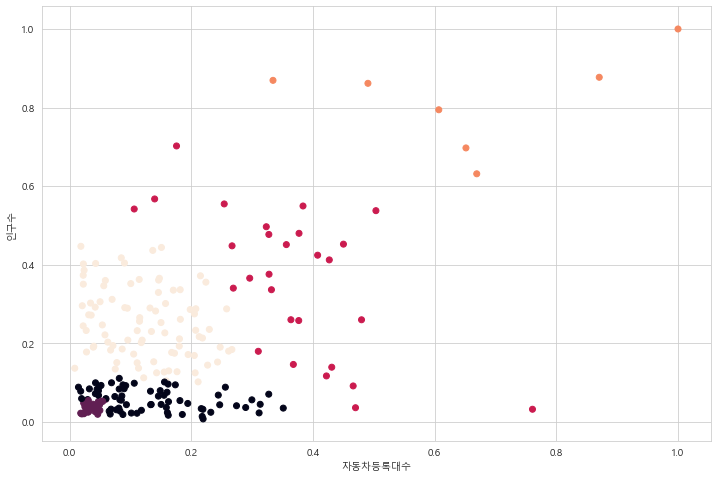

In [21]:
plt.scatter(x = X_scaled_std.iloc[:,0] ,
            y = X_scaled_std.iloc[:,1] ,
            c = y_cluster_gmm)

plt.xlabel('자동차등록대수')
plt.ylabel('인구수')

plt.show()

In [22]:
#청주와 같은 군집을 갖는 시군구 데이터프레임 생성

청주클러스터그룹값 = X_scaled_std[X_scaled_std.index == '청주시']['cluster'].values[0]
청주클러스터그룹 = X_scaled_std[X_scaled_std['cluster'] == 청주클러스터그룹값]

청주클러스터그룹.tail()

,자동차등록대수,인구수,cluster
시군구,,,
고양시,0.334217,0.869288,3
용인시,0.490274,0.861741,3
화성시,0.669134,0.631584,3
청주시,0.651395,0.697389,3
창원시,0.870514,0.877125,3


In [23]:
row_list = []  #같은 cluster로 군집화될 list들 넣어두기위해 생성

for row in range(전국교통안전지수.shape[0]):
    
    for clust_region in 청주클러스터그룹.index:
        
        if 전국교통안전지수.loc[row, '시군구'] == clust_region:
            row_list.append(row)

cj_cluster_group_안전지수 = 전국교통안전지수.loc[row_list , :]
cj_cluster_group_안전지수.tail()

,SIG_CD,SIG_ENG_NM,시군구,구분,최종점수,전체등급,교통약자 지수,교통약자등급,운전자 지수,운전자 등급,도로환경 지수,도로환경 등급,자동차등록대수,인구수
84,41280,Goyang-si,고양시,경기,70.60,C,72.07,C,71.56,C,66.95,C,220459,1044189
93,41463,Yongin-si,용인시,경기,70.28,D,67.46,D,72.08,C,66.89,C,323292,1035126
98,41590,Hwaseong-si,화성시,경기,68.51,D,73.69,C,68.27,D,61.26,D,441151,758722
124,43110,Cheongju-si,청주시,충북,57.50,E,56.34,E,54.79,E,35.78,E,429462,837749
209,48125,Changwon-si,창원시,경남,70.70,C,71.10,C,76.86,C,65.74,D,573849,1053601


##### 청주와 같은 군집내의 지역에서의 교통안전지수 비교

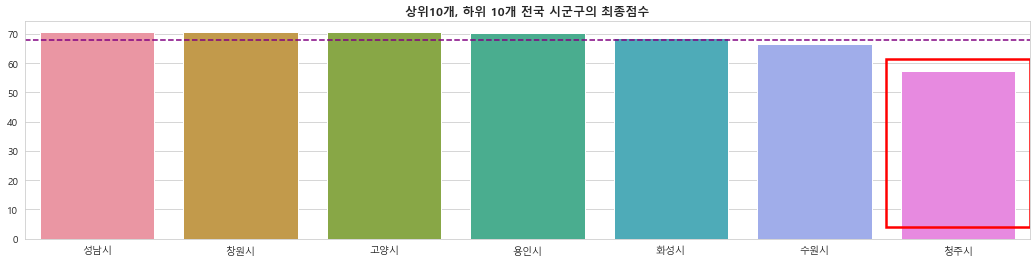

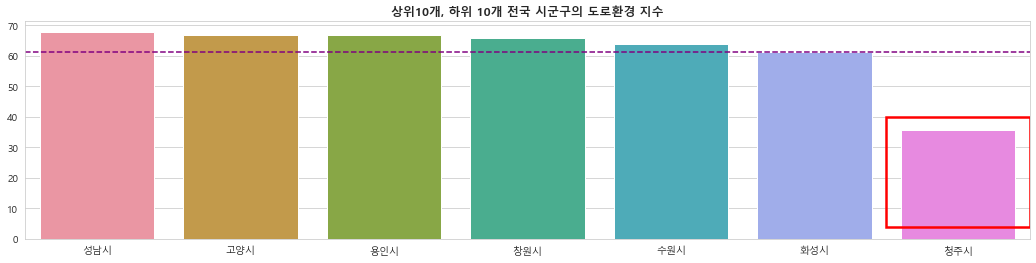

In [24]:
상위10하위10전국그래프(df = cj_cluster_group_안전지수 , column = '최종점수')
상위10하위10전국그래프(df = cj_cluster_group_안전지수 , column = '도로환경 지수')

>- 청주시는 같은 군집내에서도 상당히 교통안전지수와 도로환경지수가 낮은것을 볼 수 있다.

# 3. 링크데이터 EDA
- http://nodelink.its.go.kr 에서 다운받은 표준노드/링크.shp 파일 csv로 변환후 데이터 활용
- 표준링크(도로)데이터를 활용해 , 청주시 도로의 특성 파악을 위한 EDA (데이터 탐색적 분석)
- 표준링크데이터를 활용해 청주와 전국 도로 비교

In [25]:
전국링크데이터.columns

#각 컬럼명의 역할은 테이블정의서 참고

Index(['link_id', 'up_f_node', 'up_t_node', 'dw_f_node', 'dw_t_node',
       'max_speed', 'road_name', 'road_no', 'road_rank', 'link_type',
       'pavement', 'road_type', 'facil_name', 'tg_name', 'up_lanes',
       'dw_lanes', 'lanes', 'oneway', 'length', 'width', 'Level', 'spot_id',
       'hov_lane', 'shov_lane', 'car_lane', 'num_cross', 'barrier',
       'up_its_id', 'dw_its_id', 'sido_id', 'sigungu_id', 'emd_id', 'up_vdf',
       'dw_vdf', 'up_i_speed', 'dw_i_speed', 'up_capa', 'dw_capa',
       'emme_check', 'up_c_year', 'dw_c_year', 'end_year', 'm_check', 'm_date',
       'up_v_Link', 'dw_v_Link', 'RC_ID', 'RC_Name', 'RC_hist', 'RC_date',
       'RC_length', 'old_link_i', 'source', 'rc_desc', 'rc_apply', 'geometry',
       'SIG', 'SIG_CD', '시군구'],
      dtype='object')

In [26]:
#청주시 시군구 코드 : 43110
청주시링크데이터 = 전국링크데이터[전국링크데이터['SIG'] ==43110]
청주시링크데이터 = 청주시링크데이터.reset_index()
청주시링크데이터.drop('index', axis = 1 ,inplace = True)

청주시링크데이터.tail()

,link_id,up_f_node,up_t_node,dw_f_node,dw_t_node,max_speed,road_name,road_no,road_rank,link_type,...,RC_date,RC_length,old_link_i,source,rc_desc,rc_apply,geometry,SIG,SIG_CD,시군구
10814,567400355,321707,321708,321708,321707,40,운암계원로,0,107,32768,...,NaN,NaN,0.0,0,NaN,0.0,"LINESTRING (1022427.26905606 1845374.19841257,...",43110,43110,청주시
10815,900000055,900036,309278,309278,900036,40,NaN,0,107,32768,...,NaN,NaN,564212054.0,2,NaN,0.0,LINESTRING (992866.9583964241 1833962.82634052...,43110,43110,청주시
10816,900000070,308447,900036,900036,308447,40,NaN,0,107,32768,...,NaN,NaN,564212054.0,2,NaN,0.0,LINESTRING (992760.9443995078 1833724.76129539...,43110,43110,청주시
10817,900000072,900037,560797,560797,900037,0,NaN,0,107,32768,...,NaN,NaN,565407928.0,2,NaN,0.0,LINESTRING (1001830.383342386 1850580.11100698...,43110,43110,청주시
10818,900000117,900037,316177,316177,900037,0,NaN,0,107,32768,...,NaN,NaN,565407928.0,2,NaN,0.0,LINESTRING (1001830.383342386 1850580.11100698...,43110,43110,청주시


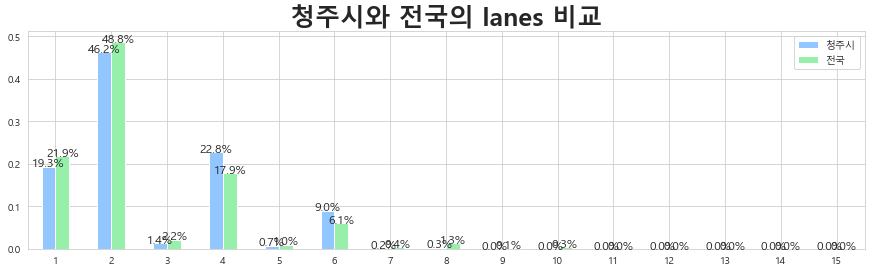

In [27]:
# 차로의 수
비교시각화(청주시링크데이터 , 전국링크데이터 , 'lanes')

>- 청주시는 비교적 1~3차선 도로가 전국평균보다 적음
>- 4차선도로와 6차선도로는 전국보다 많은것을 볼 수 있다.

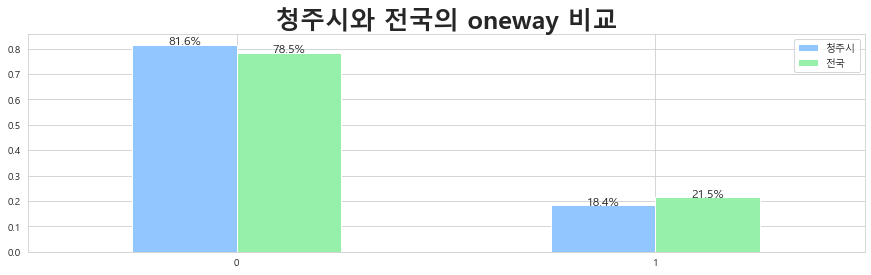

In [28]:
#일방통행 도로의 수
비교시각화(청주시링크데이터 , 전국링크데이터 , 'oneway')

>- 0 : 일방통행이 아님    1 : 일방통행도로
>- 일방통행 도로는 전국보다 적음

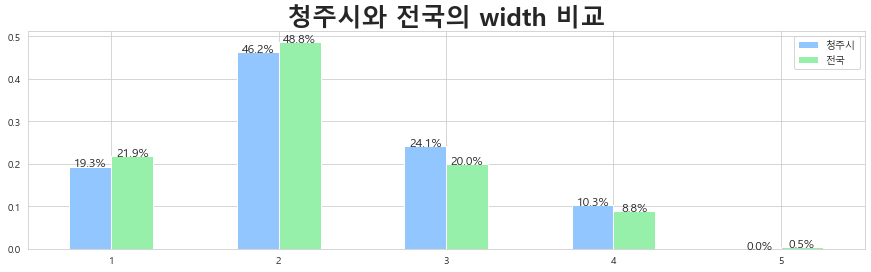

In [29]:
#도로폭
비교시각화(청주시링크데이터 , 전국링크데이터 , 'width')

>- 테이블 정의서에 자세한 설명이 부족해서 각 열이 구체적으로 의미하는 바는 파악하기 힘듦
>- but , 전국보다 도로의 폭이 넓다는 것을 알 수 있음
>- 이 점으로 회전교차로 설치에도 적합하다고 볼 수 있다.

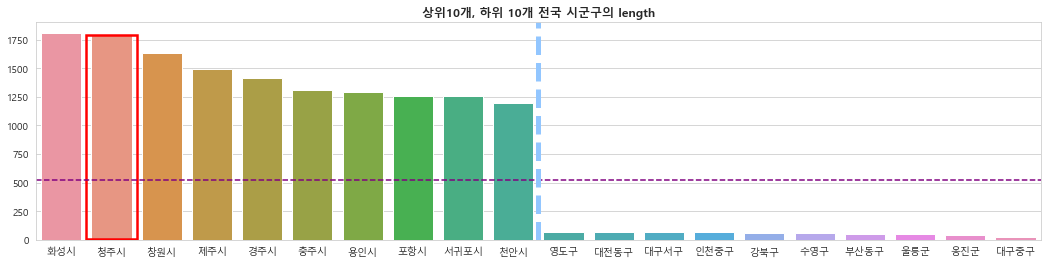

In [31]:
# 도로길이
상위10하위10전국그래프((전국링크데이터.groupby('시군구').sum()[['length']]).reset_index() , 'length')

>### 시군구별  도로의 길이가 상당히 긴것을 볼 수 있다.
